In [1]:
%matplotlib inline
from IPython.display import Image

# Elephant and Neo


*Neo* provides a set of classes for representing time series data (`SpikeTrain`, `AnalogSignalArray`, etc.), for representing the hierarchical arrangement of data in an experiment (`Segment`, `Block`) and for representing the relationship between spike trains and recording channels (`Unit`). Neo is used by a number of data visualization tools ([OpenElectrophy](http://neuralensemble.org/OpenElectrophy), [SpykeViewer](https://spyke-viewer.readthedocs.org/)) and by the [PyNN](http://neuralensemble.org/PyNN) metasimulator.

*Elephant* is a data analysis library built on Neo. It aims to provide a standard library for electrophysiology data analysis (in future, also imaging data analysis), merging functions from OpenElectrophy, SpykeViewer and [NeuroTools](http://neuralensemble.org/NeuroTools).

**Neo: electrophysiology data objects, I/O**
    
![](http://neo.readthedocs.org/en/latest/_images/neologo.png)

**Elephant: electrophysiology data analysis**

![](http://elephant.readthedocs.org/en/latest/_static/elephant_logo_sidebar.png)

## Documentation

- http://neo.readthedocs.org/
- http://elephant.readthedocs.org/

## Installation

Using Anaconda (e.g. on Windows/Mac):

    $ conda create -n neuroscience numpy scipy ipython matplotlib pip
    
    $ source activate neuroscience
    
On Ubuntu/Debian:

    $ sudo apt-get install python-numpy python-scipy python-matplotlib python-pip ipython
    
    $ virtualenv --system-site-packages ~/env/neuroscience
    
    $ source ~/env/neuroscience/bin/activate
  
Then:
  
    $ pip install quantities
    
    $ pip install git+https://github.com/NeuralEnsemble/python-neo.git@apibreak#egg=neo-apibreak
    
    $ pip install elephant

(Note that Elephant requires the development version of Neo (the future 0.4 release))

![](http://neo.readthedocs.org/en/latest/_images/neologo.png)

- a Python package for representing electrophysiology data in Python
- support for reading a wide range of neurophysiology file formats, including Spike2, NeuroExplorer, AlphaOmega, Axon, Blackrock, Plexon, Tdt
- support for writing to a subset of these formats plus general formats including MATLAB, HDF5
- deliberately limited to represention of data, with no functions for data analysis or visualization
- based on NumPy

![](http://neo.readthedocs.org/en/latest/_images/base_schematic.png)

### Reading data

In [2]:
from neo.io import ElphyIO

In [3]:
data = ElphyIO("data/5106CM3.DAT").read()

In [4]:
data

[Block with 8 segments
 # segments (N=8)
 0: Segment with 3 analogsignals
    name: 'episode 1'
    # analogsignals (N=3)
    0: AnalogSignal in 1.0 mV with 614854 float64 values
       annotations: {'channel_name': 'episode 2, channel 2',
         't_stop': array(62715.10799999999) * ms}
       channel index: None
       sampling rate: 9.80392156863 1/ms
       time: 0.0 ms to 62715.108 ms
    1: AnalogSignal in 1.0 nA with 614854 float64 values
       annotations: {'channel_name': 'episode 2, channel 3',
         't_stop': array(62715.10799999999) * ms}
       channel index: None
       sampling rate: 9.80392156863 1/ms
       time: 0.0 ms to 62715.108 ms
    2: AnalogSignal in 1.0 mV with 15372 float64 values
       annotations: {'channel_name': 'episode 2, channel 4',
         't_stop': array(62713.68) * ms}
       channel index: None
       sampling rate: 0.245098039216 1/ms
       time: 0.0 ms to 62717.76 ms
    # analogsignalarrays (N=0)
 1: Segment with 3 analogsignals
    name

In [5]:
data[0].segments[3]

Segment with 3 analogsignals
name: 'episode 4'
# analogsignals (N=3)
0: AnalogSignal in 1.0 mV with 614650 float64 values
   annotations: {'channel_name': 'episode 5, channel 2',
     't_stop': array(62694.198) * ms}
   channel index: None
   sampling rate: 9.80392156863 1/ms
   time: 0.0 ms to 62694.3 ms
1: AnalogSignal in 1.0 nA with 614650 float64 values
   annotations: {'channel_name': 'episode 5, channel 3',
     't_stop': array(62694.198) * ms}
   channel index: None
   sampling rate: 9.80392156863 1/ms
   time: 0.0 ms to 62694.3 ms
2: AnalogSignal in 1.0 mV with 15367 float64 values
   annotations: {'channel_name': 'episode 5, channel 4',
     't_stop': array(62693.28) * ms}
   channel index: None
   sampling rate: 0.245098039216 1/ms
   time: 0.0 ms to 62697.36 ms
# analogsignalarrays (N=0)

### Working with AnalogSignals and SpikeTrains

In [6]:
signal = data[0].segments[3].analogsignals[0]

In [7]:
signal.sampling_rate

array(9.803921568627452) * 1/ms

In [8]:
signal.sampling_rate.rescale('kHz')

array(9.803921568627452) * kHz

In [9]:
signal.duration

array(62694.299999999996) * ms

In [10]:
signal.units

array(1.0) * mV

In [11]:
signal.min()

array(-85.94799169820536) * mV

In [12]:
signal.mean()

array(-72.47402198326392) * mV

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16.0, 4.0)

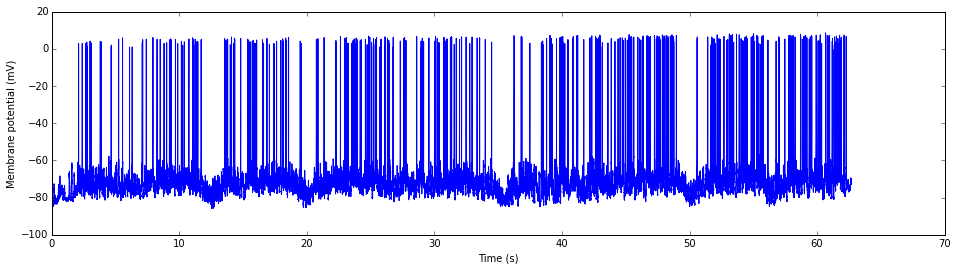

In [14]:
plt.plot(signal.times.rescale('s'), signal)
plt.xlabel("Time (s)")
plt.ylabel("Membrane potential (%s)" % signal.dimensionality.string)

In [42]:
zoom = signal[0.38*signal.size: 0.4*signal.size]
zoom.times

array([ 23823.834,  23823.936,  23824.038, ...,  25077.414,  25077.516,
        25077.618]) * ms

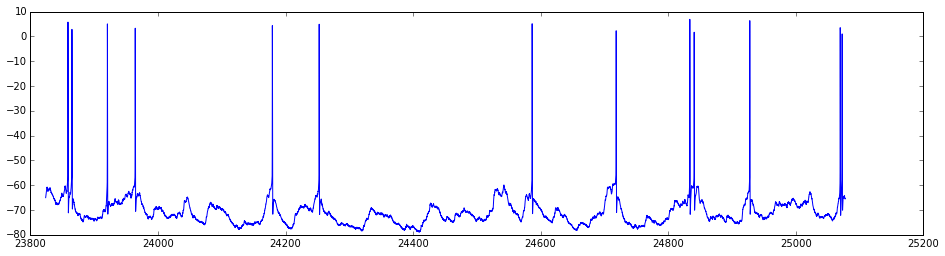

In [37]:
plt.plot(zoom.times, zoom)

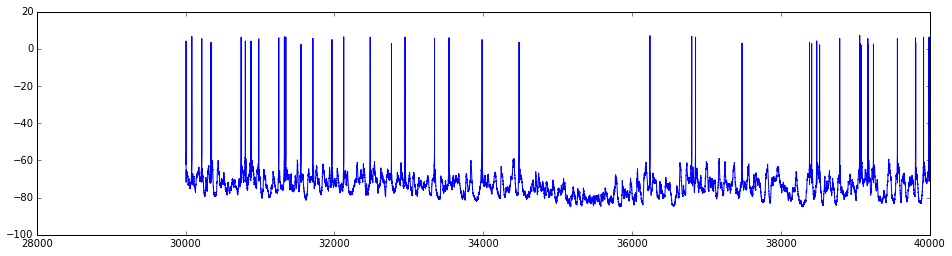

In [41]:
import quantities as pq 
zoom2 = signal.time_slice(30*pq.s, 40*pq.s)
plt.plot(zoom2.times, zoom2)

In [35]:
from quantities import mV, ms, Hz
from neo import SpikeTrain
import numpy as np

In [28]:
def extract_spikes(signal, threshold=-40*mV):
    above_threshold = (signal > threshold).astype(int)
    crossings = (above_threshold[1:] - above_threshold[:-1]) > 0
    spike_times = signal.times[1:][crossings]
    return SpikeTrain(spike_times, units='ms', t_stop=signal.t_stop, t_start=signal.t_start)
    

In [29]:
spikes = extract_spikes(zoom)

In [30]:
spikes.magnitude

array([ 30005.544,  30083.064,  30216.684,  30339.39 ,  30347.754,
        30745.656,  30802.368,  30874.176,  30878.664,  30885.09 ,
        30982.704,  31251.78 ,  31327.362,  31346.64 ,  31550.13 ,
        31710.27 ,  31966.596,  32124.696,  32480.268,  32766.48 ,
        32948.754,  33344.922,  33539.538,  33983.952,  34481.202,
        36240.498,  36802.11 ,  36853.212,  37478.37 ,  38385.048,
        38413.914,  38482.356,  38520.708,  38791.008,  39059.88 ,
        39068.244,  39078.444,  39169.122,  39174.936,  39244.806,
        39566.922,  39809.478,  39812.64 ,  39917.904,  39991.752,
        39997.566])

In [31]:
spikes.duration

array(9999.978) * ms

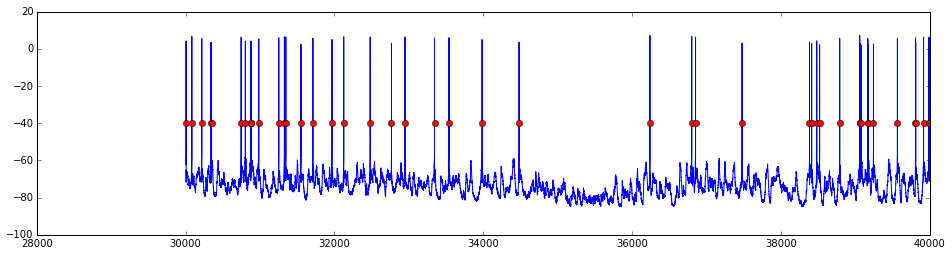

In [32]:
plt.plot(zoom.times, zoom)
plt.plot(spikes, -40*np.ones_like(spikes), 'ro')

(23850, 23870)

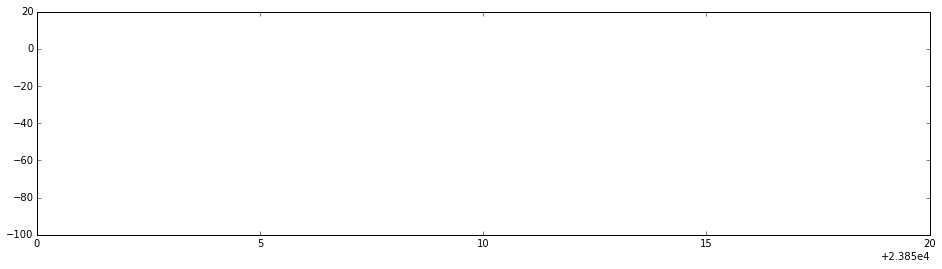

In [33]:
plt.plot(zoom.times, zoom)
plt.plot(spikes, -40*np.ones_like(spikes), 'ro')
plt.xlim(23850, 23870)

![](http://elephant.readthedocs.org/en/latest/_static/elephant_logo_sidebar.png)

- A community-developed Python toolbox for electrophysiology data analysis (in future, also optical imaging)
- Aims to merge data analysis methods from NeuroTools, OpenElectrophy, SpykeViewer
- Current functionality:
    - Spike train statistics
    - Signal processing
    - Spectral analysis
    - Spike-triggered average
    - Stochastic spike train generation
    - Stochastic spike train generation
    - Spike train surrogates
    - Data format conversions
    - Spike train correlation analysis

### A note on versions

Elephant requires the development version of Neo (the future version 0.4). In Neo 0.4, `AnalogSignal` and `AnalogSignalArray` will be merged; Elephant works only with `AnalogSignalArray`, so we need to convert our signals:

In [ ]:
from neo import AnalogSignalArray
signal_arr = AnalogSignalArray(signal.reshape(-1, 1),
                               sampling_rate=signal.sampling_rate)
zoom_arr = signal_arr[0.38*signal.size: 0.4*signal.size, :]

### Signal processing

In [ ]:
from elephant.signal_processing import butter

In [ ]:
high_pass = butter(zoom_arr, highpass_freq=50*Hz)
low_pass = butter(zoom_arr, lowpass_freq=200*Hz)
band_pass = butter(zoom_arr, lowpass_freq=200*Hz, highpass_freq=50*Hz)

In [ ]:
plt.plot(zoom_arr.times, zoom_arr, 'b-',
         high_pass.times, high_pass + 40*mV, 'g-',
         low_pass.times, low_pass - 40*mV, 'r-')
plt.xlabel("Time (%s)" % zoom_arr.times.dimensionality.string)

### Spectral analysis

In [ ]:
from elephant.spectral import welch_psd

In [ ]:
freqs, psd = welch_psd(signal_arr)

In [ ]:
plt.plot(freqs, psd[0])
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Frequency (%s)" % freqs.dimensionality.string)

### Spike train statistics

In [ ]:
from elephant.statistics import cv, lv, isi, fanofactor, mean_firing_rate

In [ ]:
spikes = extract_spikes(signal)

In [ ]:
isis = isi(spikes)

In [ ]:
isis.min()

In [ ]:
isis.max()

In [ ]:
cv(isis)

In [ ]:
mean_firing_rate(spikes).rescale('Hz')

In [ ]:
from elephant.statistics import time_histogram

In [ ]:
binned_signal = time_histogram([spikes], 100*ms)

In [ ]:
x = binned_signal.times
y = binned_signal[:, 0]
plt.plot(x, y)
plt.gca().fill_between(x, y, where=y>=0, color='blue')

### Kernels

In [ ]:
import sys
sys.path.append('./elephant_dev/')
import kernels
import quantities as pq

In [ ]:
kernel = kernels.AlphaKernel(sigma=100*ms, direction=1)
segment = np.linspace(-1.0, 1.0, num=401)*pq.s
plt.plot(segment, kernel(segment))

In [ ]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (16.0, 6.0)
kernel_types = [obj for obj in kernels.__dict__.values() if isinstance(obj, type) and issubclass(obj, kernels.Kernel) and hasattr(obj, "_evaluate") and obj is not kernels.Kernel and obj is not kernels.SymmetricKernel]
# print(kernel_types)
kernel_list = [kernel_type(sigma=10*ms, direction=1) for kernel_type in kernel_types]
segment = np.linspace(-40, 40, 101)*ms
bin_width = segment[1] - segment[0]
for j, kernel in enumerate(kernel_list):
    plt.subplot(2, 4, j + 1)
    plt.bar(segment, kernel(segment).magnitude, width=bin_width, color='rgbymck'[j], lw=0)
    plt.title(kernel.__class__.__name__)

### Instantaneous Rate

In [ ]:
from statistics_dev import instantaneous_rate

In [ ]:
k = kernels.RectangularKernel(sigma=100*ms, direction=1)
rate = instantaneous_rate(spikes, signal.sampling_period, k)
plt.plot(rate.times, rate)
plt.xlabel(rate.times.units)
plt.ylabel(rate.units)

### Generating random spike trains

In [ ]:
from elephant.spike_train_generation import homogeneous_gamma_process

In [ ]:
spiketrains = [homogeneous_gamma_process(2.0, 50*Hz, 0*ms, 1000*ms)
               for i in range(100)]

In [ ]:
for i, spiketrain in enumerate(spiketrains):
    plt.plot(spiketrain, i * np.ones_like(spiketrain), '.')

### Correlations

In [ ]:
from elephant.spike_train_correlation import corrcoef
from elephant.conversion import BinnedSpikeTrain

In [ ]:
spiketrains[75:80] = [spiketrains[25]]*5   # introduce some correlations!

In [ ]:
for i, spiketrain in enumerate(spiketrains):
    plt.plot(spiketrain, i * np.ones_like(spiketrain), '.')

In [ ]:
binned_spikes = BinnedSpikeTrain(spiketrains, binsize=5*ms)

In [ ]:
binned_spikes.to_bool_array()

In [ ]:
cc_matrix = corrcoef(binned_spikes)

In [ ]:
from matplotlib import cm
plt.imshow(cc_matrix, cmap=cm.hot)
plt.colorbar()

### Cross-Correlations

In [ ]:
# import sys
# sys.path.append('./elephant_dev/')
from spike_train_correlation_dev import cross_correlation_histogram

In [ ]:
CCH = cross_correlation_histogram(
        BinnedSpikeTrain(spiketrains[76],binsize= 2*ms),BinnedSpikeTrain(spiketrains[78],binsize = 2*ms)
        ,window=[-100,100])[0]

In [ ]:
plt.bar(left=CCH.times.magnitude,height=CCH[:, 0].magnitude,width=CCH.sampling_period.magnitude)

## pairwise and higher order synchrony

### Unitary Event analysis

In [ ]:
from neo.io import NeoHdf5IO
import unitary_event_analysis_dev as ue
import plot_uitary_events as plot_ue

In [ ]:
block = NeoHdf5IO("data/Data_experiment.h5")
sts1 = block.read_segment().segments[0].spiketrains
sts2 = block.read_segment().segments[1].spiketrains
spiketrains = np.vstack((sts1,sts2)).T

print 'calculating UE ...'
UE = ue.jointJ_window_analysis(spiketrains, binsize=5*ms, winsize=100*ms, winstep=10*ms,
                                pattern_hash = [3])

plot_ue._plot_UE(
        spiketrains,UE,ue.jointJ(0.05),binsize=5*ms,winsize=100*ms,winstep=10*ms,
        pat=ue.inverse_hash_from_pattern([3], N=2), N=2,
        t_winpos=ue._winpos(0*ms,spiketrains[0][0].t_stop,winsize=100*ms,winstep=10*ms))

### Compund Poisson Process

In [ ]:
import stocmod

In [ ]:
# Specify the amplitude distribution of the model
A = np.zeros(101) 
A[[1,10]] = .96, .04

# Generate the CPP data
cpp = stocmod.cpp(A, t_stop=10000*ms, rate=20*Hz)

# Compute the population histogram and the complexity distribution
pophist = time_histogram(cpp, binsize=2*ms)
complexity_cpp = np.histogram(
        pophist.magnitude, bins=range(0, len(cpp)+2),normed = 1)


# Plot the results
plt.figure(figsize = (8,6))
plt.subplot(2,1,1)
for i, spiketrain in enumerate(cpp):
    plt.plot(spiketrain, i * np.ones_like(spiketrain), ',',color = 'b')
plt.xlim(0,2000)
ylim = plt.gca().get_ylim()
plt.subplot(2,1,2)
plt.bar(complexity_cpp[1][1:len(A)+1], A, color='r', label='amplitude distrib.')
plt.plot(complexity_cpp[1][1:], complexity_cpp[0], label='complexity distrib.')
plt.ylim([0, 0.25])
plt.xlabel('probability', size=12)
plt.ylabel('complexity', size=12)
plt.suptitle('CPP', size=14)
plt.legend()

### Cubic

In [ ]:
import cubic

In [ ]:
pophist = time_histogram(cpp, binsize=1*ms)
xi, p, k = cubic.cubic(pophist, alpha=0.05)

xi_true = np.where([A>0])[-1][-1]

ax = plt.subplot(121)
ax.bar(left=np.arange(.5, len(p)+.5), height=p, color='darkgreen')
ax.set_xlim(.5, len(p)+.5)
ax.plot(ax.get_xlim(), [0.05, 0.05], 'r--', lw=2)
ax.text(.1, .9, r'$\hat\xi=%d$ $(\xi_{true}=%d)$' %(xi, xi_true), 
        transform=ax.transAxes, size=14)
plt.show()

### Roadmap

- spike train metrics (Victor-Purpura distance, Van Rossum distance, ...)
- spike train covariance
- frequent itemset mining (*cf* Torre et al. 2013)
- signal coherence
- generation of correlated random spike trains
- support for optical imaging data
- ...

### The goals of Elephant

- develop a free library of well-tested data analysis methods for neuroscience
- stop reinventing the wheel

![](figs/cavemen.png)

### Contributing to Neo and Elephant

#### Reporting bugs

   
- https://github.com/NeuralEnsemble/python-neo/issues
- https://github.com/NeuralEnsemble/elephant/issues

![](figs/neo_issue_tracker.png)

#### Contributing code

![](figs/fork.png)

- keep your own, customized version of Elephant
- when you feel ready, submit a "pull request"
- after code review, your functions are merged into the main Elephant release

## Thanks

The following people have contributed code and/or ideas to the current version of Elephant.

- Alper Yegenoglu [1]
- Andrew Davison [2]
- Detlef Holstein [2]
- Eilif Muller [3, 4]
- Emiliano Torre [1]
- Julia Sprenger [1]
- Junji Ito [1]
- Michael Denker [1]
- Paul Chorley [1]
- Pierre Yger [2]
- Pietro Quaglio [1]
- Richard Meyes [1]
- Vahid Rostami [1]
- Subhasis Ray [5]


1. Institute of Neuroscience and Medicine (INM-6), Computational and Systems Neuroscience & Institute for Advanced Simulation (IAS-6), Theoretical Neuroscience, Jülich Research Centre and JARA, Jülich, Germany
2. Unité de Neurosciences, Information et Complexité, CNRS UPR 3293, Gif-sur-Yvette, France
3. Electronic Visions Group, Kirchhoff-Institute for Physics, University of Heidelberg, Germany
4. Brain-Mind Institute, Ecole Polytechnique Fédérale de Lausanne, Switzerland
5. NIH–NICHD, Laboratory of Cellular and Synaptic Physiology, Bethesda, Maryland 20892

The following people have contributed code and/or ideas to the current version of Neo.

- Samuel Garcia [1]
- Andrew Davison [2]
- Chris Rodgers [3]
- Pierre Yger [2]
- Yann Mahnoun [4]
- Luc Estabanez [2]
- Andrey Sobolev [5]
- Thierry Brizzi [2]
- Florent Jaillet [6]
- Philipp Rautenberg [5]
- Thomas Wachtler [5]
- Cyril Dejean [7]
- Robert Pröpper [8]
- Domenico Guarino [2]


1. Centre de Recherche en Neuroscience de Lyon, CNRS UMR5292 - INSERM U1028 - Universite Claude Bernard Lyon 1
2. Unité de Neuroscience, Information et Complexité, CNRS UPR 3293, Gif-sur-Yvette, France
3. University of California, Berkeley
4. Laboratoire de Neurosciences Intégratives et Adaptatives, CNRS UMR 6149 - Université de Provence, Marseille, France
5. G-Node, Ludwig-Maximilians-Universität, Munich, Germany
6. Institut de Neurosciences de la Timone, CNRS UMR 7289 - Université d’Aix-Marseille, Marseille, France
7. Centre de Neurosciences Integratives et Cognitives, UMR 5228 - CNRS - Université Bordeaux I - Université Bordeaux II
8. Neural Information Processing Group, TU Berlin, Germany